In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed=42


import os
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
    print("Yeah we have a GPU!")
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np
from scipy.spatial import distance_matrix

from gdeep.decision_boundary.decision_boundary_calculator import *
from gdeep.create_nets.sample_nn import SampleCNN_MNIST_SAMPLE,\
    SampleCNN_MNIST_SAMPLE_2
from gdeep.create_nets import Net
from gdeep.plotting.visualize_hd_db import LowDimensionalPlane

try:
    from color_scale import lab_color_scale
except:
    pass

# Setting up CNN and Training on MINIST_0_1

In [5]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

# Train set
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

# Filters for labels 0 and 1
trainset_0_1 = torch.utils.data.Subset(trainset, torch.stack((trainset.targets == 0, trainset.targets == 1), axis=-1).any(-1).nonzero()[:,0])

trainloader = torch.utils.data.DataLoader(trainset_0_1, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True)


# Test set
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
# Filters for labels 0 and 1
testset_0_1 = torch.utils.data.Subset(testset, torch.stack((testset.targets == 0, testset.targets == 1), axis=-1).any(-1).nonzero()[:,0])
testloader = torch.utils.data.DataLoader(testset_0_1, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True)

In [6]:
digit_detect_nn = SampleCNN_MNIST_SAMPLE(smooth=True).to(dev)

print("Trainable parameters of NN:",\
    sum(p.numel() for p in digit_detect_nn.parameters()), '\n')

print('Neural network architecture')
print(digit_detect_nn)

#for param in digit_detect_nn.parameters():
#    torch.nn.init.normal_(param, 0., 0.01)

Trainable parameters of NN: 61026 

Neural network architecture
SampleCNN_MNIST_SAMPLE(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [7]:
n_epoch = 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(digit_detect_nn.parameters(), lr=0.001, momentum=0.9)


for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(dev)
        labels = labels.to(dev)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = digit_detect_nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 0.684
[1,    40] loss: 0.578
[1,    60] loss: 0.420
[1,    80] loss: 0.229
[1,   100] loss: 0.097
[1,   120] loss: 0.053
[1,   140] loss: 0.033
[1,   160] loss: 0.024
[1,   180] loss: 0.016
[2,    20] loss: 0.017
[2,    40] loss: 0.012
[2,    60] loss: 0.017
[2,    80] loss: 0.017
[2,   100] loss: 0.013
[2,   120] loss: 0.013
[2,   140] loss: 0.010
[2,   160] loss: 0.010
[2,   180] loss: 0.012
[3,    20] loss: 0.007
[3,    40] loss: 0.008
[3,    60] loss: 0.009
[3,    80] loss: 0.010
[3,   100] loss: 0.009
[3,   120] loss: 0.007
[3,   140] loss: 0.018
[3,   160] loss: 0.013
[3,   180] loss: 0.005
Finished Training


In [ ]:
for param in digit_detect_nn.parameters():
    param.requires_grad = False
model = lambda x: F.softmax(digit_detect_nn(x), dim=-1)[:, 1] #- torch.tensor([0.5])

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(dev)
        labels = labels.to(dev)
        outputs = digit_detect_nn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100. * correct / total))

Accuracy of the network on the 10000 test images: 99.763593 %


# Sampling points on the decision boundary

using gradient flow method

In [68]:
steps = 1000

dc_samples = {'spacial': [], 'gradients': []}

batch_num = 0
labels = []
for initial_points_batch, label in iter(testloader):
    initial_points_batch.to(dev, non_blocking=True)
    labels.append(label)
    g = GradientFlowDecisionBoundaryCalculator(
                model=model,
                initial_points=initial_points_batch,
                optimizer=lambda params: torch.optim.Adam(params)
    )
    #TODO: clip to [0,1]
    g.step(steps)

    y = g.get_decision_boundary()
    delta = torch.zeros_like(y, requires_grad=True)
    loss = torch.sum(model(y+delta))
    loss.backward()
    dc_samples['gradients'].append(delta.grad.detach())

    dc_samples['spacial'].append(y.detach().cpu())
    
    batch_num +=1
    if batch_num > 10:
        break

In [69]:
dc_samples_tensor = {'spacial': [], 'gradients': []}
dc_samples_tensor['spacial'] = torch.cat(dc_samples['spacial'], axis=0)
dc_samples_tensor['gradients'] = torch.cat(dc_samples['gradients'], axis=0).reshape([-1, 28*28])
dc_samples_tensor['normal'] = dc_samples_tensor['gradients'] / dc_samples_tensor['gradients'].norm(dim=1)[:, None]

In [107]:
init_pt_batch = []
batch_num = 0
for initial_points_batch, _ in iter(testloader):
    init_pt_batch.append(initial_points_batch)
    batch_num +=1
    if batch_num > 10:
        break

init_pt_tensor = torch.cat(init_pt_batch, axis=0)

In [109]:
px.histogram(torch.sqrt(torch.sum((init_pt_tensor.reshape(-1, 28*28) - dc_samples_tensor['spacial'].reshape(-1, 28*28))**2, 1)))

In [75]:
labels_np = torch.cat(labels).numpy()

In [89]:
db_sample = dc_samples_tensor['spacial'].reshape(-1, 28*28)
avg_norm = dc_samples_tensor['normal'].mean(0)
avg_norm_normed = avg_norm / avg_norm.norm()

normal_comp = torch.einsum('bi,i->b', db_sample, avg_norm_normed)
proj_comp = db_sample - torch.einsum('b,i->bi', normal_comp, avg_norm_normed)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(proj_comp)
proj_pca = pca.transform(proj_comp)
pca_normal = np.concatenate((normal_comp.reshape(-1, 1).numpy(), proj_pca), -1)

In [90]:
import pandas as pd
df = pd.DataFrame(pca_normal, columns = ["x"+str(i) for i in range(len(pca_normal[0]))])
fig = px.scatter_3d(df,x="x0",y="x1", z="x2")
fig.show()

In [95]:
#dc_samples_random_tensor

db_sample = dc_samples_random_tensor['spacial'].reshape(-1, 28*28)
avg_norm = dc_samples_random_tensor['normal'].mean(0)
avg_norm_normed = avg_norm / avg_norm.norm()

normal_comp = torch.einsum('bi,i->b', db_sample, avg_norm_normed)
proj_comp = db_sample - torch.einsum('b,i->bi', normal_comp, avg_norm_normed)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(proj_comp)
proj_pca = pca.transform(proj_comp)
pca_normal = np.concatenate((normal_comp.reshape(-1, 1).numpy(), proj_pca), -1)

In [96]:
import pandas as pd
df = pd.DataFrame(pca_normal, columns = ["x"+str(i) for i in range(len(pca_normal[0]))])
fig = px.scatter_3d(df,x="x0",y="x1", z="x2")
fig.show()

In [58]:
proj_pca.shape

(704, 2)

In [ ]:


PCA = PCA(n_components=2)
= dc_samples_tensor['spacial']

In [122]:
# Save sampled points to file

db_file = os.path.join('tensors', 'db_normal')
try:
    torch.save(dc_samples_tensor, db_file)
except:
    pass
try:
    dc_samples_tensor_loaded = torch.load(db_file)
except:
    pass

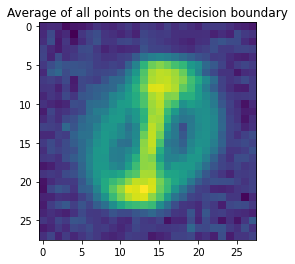

In [116]:
plt.imshow(dc_samples_tensor['spacial'].mean(0)[0,:,:])
plt.title("Average of all points on the decision boundary")
plt.show()

In [16]:
for i in range(3):
    plt.imshow(dc_samples['gradients'][0][i,0,:,:])
    plt.colorbar()
    plt.show()

NameError: name 'dc_samples' is not defined

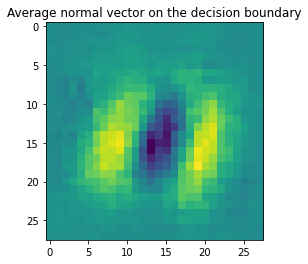

In [120]:
plt.imshow(dc_samples_tensor['normal'].mean(0).reshape((28, 28)))
plt.title("Average normal vector on the decision boundary")
plt.show()

In [171]:
dc_spacial_flatten = dc_samples_tensor['spacial'].reshape((-1, 28 * 28))

avg_nn_dist = np.amin(distance_matrix(dc_spacial_flatten, dc_spacial_flatten) + np.diag([np.inf] * dc_spacial_flatten.shape[0]), axis=0).mean()

print(f'Average nearest neighbor distance of sampled points on DB: {avg_nn_dist}')


res = torch.mm(dc_samples_tensor['normal'], dc_samples_tensor['normal'].transpose(0,1))

# Plot histgram of cosine similarity of points on the decision boundary
#fig = px.histogram(res.reshape(-1))
#fig.update_layout(title_text='Cosine similarity of normal vectors on DB')
#fig.show()

Average nearest neighbor distance of sampled points on DB: 15.338492198244351


# Decision boundary complexity analysis

In [206]:
first_train_batch = list(trainloader)[0][0]
model(first_train_batch) > 0.5

tensor([False,  True, False,  True,  True, False,  True, False, False,  True,
         True, False,  True, False, False,  True,  True, False, False,  True,
        False, False,  True, False,  True,  True, False, False, False,  True,
        False,  True,  True,  True, False, False,  True,  True, False, False,
         True, False, False,  True, False, False,  True,  True,  True,  True,
         True, False,  True,  True, False,  True,  True,  True, False, False,
         True,  True,  True,  True])

In [13]:
x = first_train_batch[0]
v1 = first_train_batch[2] - x
v2 = first_train_batch[5] - x
v = torch.stack((v1, v2))
#v3 = first_train_batch[3] - x 
#v = torch.stack((v1, v2, v3))

plane = LowDimensionalPlane(x, v)

NameError: name 'first_train_batch' is not defined

In [47]:
x = dc_samples_tensor['spacial'][10]
v1 = dc_samples_tensor['spacial'][2] - x
v2 = dc_samples_tensor['spacial'][6] - x
v = torch.stack((v1, v2))

plane = LowDimensionalPlane(x, v)

In [50]:
a, b = np.mgrid[0:1:50j, 0:1:50j]
mask = a + b <= 1
a, b = a[mask], b[mask]
coords = np.stack((a, b, 1 - a - b))
coords_tensor = torch.tensor(coords, dtype=torch.float32)
value = model(plane.embed_tensor(coords_tensor[:2].transpose(1,0))).numpy()
fig = ff.create_ternary_contour(coords, value, showscale=True)
fig.show()

In [30]:
model(plane.embed_tensor(torch.tensor(np.stack((a, b)), dtype=torch.float32).reshape((-1, 2)))).reshape(50, 50)

import plotly.graph_objects as go
import pandas as pd
import numpy as np


a, b = np.mgrid[0:1:50j, 0:1:50j]
z = model(plane.embed_tensor(torch.tensor(np.stack((a, b)), dtype=torch.float32).reshape((-1, 2)))).reshape(50, 50)

fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
        "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
    },
    z = z
    ))
fig.update_layout(
        scene = {
            "xaxis": {"nticks": 20},
            "zaxis": {"nticks": 4},
            'camera_eye': {"x": 0, "y": -1, "z": 0.5},
            "aspectratio": {"x": 1, "y": 1, "z": 0.2}
        })
fig.show()

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.4946, 0.4946, 0.4946],
        [0.4873, 0.4873, 0.4873,  ..., 0.4787, 0.4787, 0.4787],
        [0.4694, 0.4694, 0.4694,  ..., 0.4605, 0.4605, 0.4605],
        ...,
        [0.4885, 0.4735, 0.4547,  ..., 0.1031, 0.0844, 0.0686],
        [0.4885, 0.4735, 0.4547,  ..., 0.1031, 0.0844, 0.0686],
        [0.4885, 0.4735, 0.4547,  ..., 0.1031, 0.0844, 0.0686]])

In [49]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np


a, b = np.mgrid[0:1:50j, 0:1:50j]
z = model(plane.embed_tensor(torch.tensor(np.stack((a.reshape(-1), b.reshape(-1)), -1), dtype=torch.float32))).reshape(50, 50)

fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
        "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
    },
    z = z
    ))
fig.update_layout(
        scene = {
            "xaxis": {"nticks": 20},
            "zaxis": {"nticks": 4},
            'camera_eye': {"x": 0, "y": -1, "z": 0.5},
            "aspectratio": {"x": 1, "y": 1, "z": 1}
        })
fig.show()

In [18]:
import plotly.graph_objects as go
import numpy as np
a, b = np.mgrid[0:1:50j, 0:1:50j]
coords = np.stack((a, b))
coords_tensor = torch.tensor(coords, dtype=torch.float32)
value = model(plane.embed_tensor(coords_tensor.transpose(2,0).reshape((-1, 2)))).numpy()
fig = go.Figure(data=[go.Surface(z=value, x=a, y=b)])
fig.show()

In [17]:
coords_tensor.shape

torch.Size([2, 50, 50])

In [318]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=value, x=a, y=b)])
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [9]:
values

db_file = os.path.join('/home/reinauer/EPFL/giotto-deep/examples/tensors', 'implicit_plot_values')

torch.save(values, db_file)

NameError: name 'values' is not defined

In [2]:
import os
import torch
db_file = os.path.join('/home/reinauer/EPFL/giotto-deep/examples/tensors', 'implicit_plot_values')
values = torch.load(db_file).numpy()

In [1]:
import ipyvolume as ipv

ModuleNotFoundError: No module named 'ipyvolume'

In [24]:
import numpy as np
import torch
from mayavi import mlab

size = 60
mlab.clf()
a, b, c = np.mgrid[-3:3:size*1j, -3:3:size*1j, -3:3:size*1j]

black = (0,0,0)
# Plot decision boundary
coords = np.stack((a, b, c))
coords_tensor = torch.tensor(coords, dtype=torch.float32).transpose(-1, 0)
values = model(plane.embed_tensor(coords_tensor.reshape((-1, 3)))).reshape((size, size, size)) -0.5

""" mlab.contour3d(a, b, c, values, contours=[0.1])
mlab.points3d([0.], [0.], [0.], scale_factor=0.1, color=black)
mlab.points3d([1., 0., 0.], [0., 1., 0.], [0., 0., 1.], scale_factor=0.1)
mlab.axes()
mlab.show() """

ipv.figure()
ipv.volshow(values)
ipv.plot_isosurface(f, color='gray')
ipv.show()

In [55]:
x = dc_samples_tensor['spacial'][10]
v1 = dc_samples_tensor['spacial'][2] - x
v2 = dc_samples_tensor['spacial'][6] - x
v3 = dc_samples_tensor['spacial'][7] - x
v = torch.stack((v1, v2, v3))

plane_3d = LowDimensionalPlane(x, v)

In [1]:
import numpy as np
import ipyvolume as ipv

n_delta = 55
t = np.linspace(-1, 1, n_delta)
x, y, z = np.meshgrid(t,t,t)
#f = x**2 + y**2 + z**2
values = model(plane_3d.embed_tensor(torch.tensor(np.stack((x.reshape(-1), y.reshape(-1), z.reshape(-1)), -1), dtype=torch.float32))).reshape(n_delta, n_delta, n_delta)

ipv.figure()
#ipv.volshow(f)
ipv.plot_isosurface(values.numpy(), level = 0.5, color='gray')
ipv.show()

NameError: name 'model' is not defined

In [59]:
x.shape

(21, 21, 21)

In [1]:
from mayavi import mlab
mlab.savefig?

Signature:
mlab.savefig(
    filename,
    size=None,
    figure=None,
    magnification='auto',
    **kwargs,
)
Docstring:
Save the current scene.
The output format are deduced by the extension to filename.
Possibilities are png, jpg, bmp, tiff, ps, eps, pdf, rib (renderman),
oogl (geomview), iv (OpenInventor), wrl, vrml, obj (wavefront),
x3d, pov (povray).

**Parameters**

:size: the size of the image created (unless magnification is
       set, in which case it is the size of the window used
       for rendering).

:figure: the figure instance to save to a file.

:magnification: the magnification is the scaling between the
                pixels on the screen, and the pixels in the
                file saved. If you do not specify it, it will be
                calculated so that the file is saved with the
                specified size. If you specify a magnification,
                Mayavi will use the given size as a screen size,
                and the file size will be 'magnifi

In [43]:
model(torch.cat((x.reshape(1, 1, 28, 28),v)))

tensor([1.8208e-04, 1.9666e-01, 9.9998e-01, 9.9999e-01])

In [45]:
plane.project_tensor(torch.cat((x.reshape(1, 1, 28, 28),v)))

tensor([[   0.0000,    0.0000,    0.0000],
        [ 440.0168,  635.1314,  519.4711],
        [ 260.6168, 1959.0924, 1161.5271],
        [ 227.5854, 1244.1560, 1573.2346]])

In [47]:
v == plane.v

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]],


        [[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]],


        [[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True, 

# Take random starting points for gradient flow

In [93]:
steps = 1000

trajectory = []

dc_samples_random = {'spacial': [], 'gradients': []}

initial_points_batch = torch.rand((600, 1, 28, 28))
labels = model(initial_points_batch) > 0.5
#print(model(initial_points_batch[:1])[0,0])
initial_points_batch.to(dev, non_blocking=True)
g = GradientFlowDecisionBoundaryCalculator(
            model=model,
            initial_points=initial_points_batch,
            optimizer=lambda params: torch.optim.Adam(params)
)
#TODO: clip to [0,1]
for step in range(steps):
    g.step()
    trajectory.append(g.get_decision_boundary().clone().detach()[0])

y = g.get_decision_boundary()
delta = torch.zeros_like(y, requires_grad=True)
loss = torch.sum(model(y+delta))
loss.backward()
dc_samples_random['gradients'].append(delta.grad.detach())

dc_samples_random['spacial'].append(y.detach().cpu())

In [94]:
dc_samples_random_tensor = {'spacial': [], 'gradients': []}
dc_samples_random_tensor['spacial'] = torch.cat(dc_samples_random['spacial'], axis=0)
dc_samples_random_tensor['gradients'] = torch.cat(dc_samples_random['gradients'], axis=0).reshape([-1, 28*28])
dc_samples_random_tensor['normal'] = dc_samples_random_tensor['gradients'] / dc_samples_random_tensor['gradients'].norm(dim=1)[:, None]

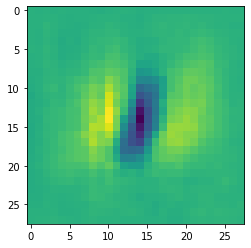

In [102]:
plt.imshow(dc_samples_random_tensor['gradients'].mean(0).reshape((28, 28)))

In [297]:
res = torch.mm(dc_samples_random_tensor['normal'], dc_samples_random_tensor['normal'].transpose(0,1))


px.histogram(res.reshape(-1))

# Curvature analysis

In [62]:
def compute_principal_curvatures(model, x, gradient):
    assert x.shape == torch.Size([1, 28, 28])
    x = x.reshape((1, 1, 28, 28))
    n = 28 * 28
    gradient = gradient.reshape(28 * 28)
    normal_gradient = gradient / torch.norm(gradient)
    f_nn = lambda x: model(x)[0]

    hessian = torch.autograd.functional.hessian(f_nn, x).reshape(28*28, 28*28)
    x_flat = x.reshape(28*28)

    projection_tangent = torch.eye(n) - torch.einsum('i,j->ij', normal_gradient, normal_gradient)
    curvature_matrix = (projection_tangent @ hessian @ projection_tangent)/torch.norm(gradient)
    principal = torch.symeig(curvature_matrix, eigenvectors=True)
    principal_curvatures = principal.eigenvalues
    principal_directions = principal.eigenvectors
    return principal_curvatures, principal_directions, curvature_matrix

In [64]:
for i in range(1):#range(dc_samples_random_tensor['spacial'].shape[0]):
    x = dc_samples_random_tensor['spacial'][i].reshape((1,28,28))
    gradient = dc_samples_random_tensor['gradients'][i].reshape((1,1,28,28))
    print(torch.norm(gradient))

    principal_curvatures, principal_directions, curvature_matrix = compute_principal_curvatures(model, x, gradient)

    print(i, principal_curvatures.min(), principal_curvatures.max(), principal_curvatures[1])

px.histogram(principal_curvatures)

tensor(3.0993e-06)
0 tensor(-0.0080) tensor(0.0068) tensor(-0.0077)


In [34]:
principal_curvatures.mean()

tensor(-0.0006)

In [65]:
print('minimal principal curvature', principal_curvatures[-1])
v2 = principal_directions[:, 0]

minimal principal curvature tensor(0.0068)


In [175]:
torch.sum(torch.max(model(torch.rand(100000, 1, 28, 28)), dim=1).indices)

tensor(0)

In [186]:
torch.sum(torch.max(model(iter(testloader).next()[0]), dim=1).indices)

tensor(41)

In [7]:
model(torch.rand(1000, 1, 28, 28))

NameError: name 'model' is not defined

# Model projection

In [89]:
point = 2

x = dc_samples_random_tensor['spacial'][point].reshape((1, 28, 28))
gradient = dc_samples_random_tensor['gradients'][point].reshape((1,28,28))
normal = dc_samples_random_tensor['normal'][point].reshape((1,28,28))

principal_curvatures, principal_directions, curvature_matrix = compute_principal_curvatures(model, x, gradient)

v1 = normal
v2 = principal_directions[:, -1].reshape((1,28,28))

v = torch.stack((v1,v2))

plane = LowDimensionalPlane(x, v)

In [67]:
px.histogram(principal_curvatures)

In [90]:
x_range = 1.
y_range = x_range
delta = 0.05
grid_x, grid_y = torch.meshgrid(torch.arange(-x_range, x_range, delta), torch.arange(-y_range, y_range, delta))
grid = torch.stack((grid_x.reshape(-1), grid_y.reshape(-1)), dim=1)
model_val = model(plane.embed_tensor(grid)).reshape(grid_x.shape)

In [91]:
trajecotry_tensor = torch.cat(trajectory)

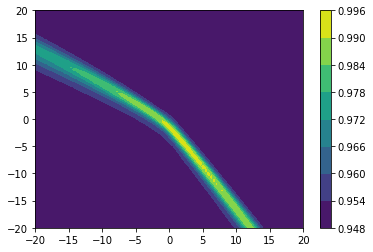

In [103]:
plt.contourf(grid_x, grid_y, model_val.detach())
plt.colorbar()
#plt.scatter(x_traj, y_traj, c='r')

In [93]:
plane = LowDimensionalPlane(torch.rand((1, 28, 28)), torch.rand(2, 1, 28, 28))

In [94]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
from gdeep.create_nets.sample_nn import SmoothNet

# create random network
torch.manual_seed(3)
n = 2 # dimensional input space
model_projection = lambda y: model(plane.embed_tensor(y))

# create grid and compute grid values
plot_range = 20.
steps = 100
x_range = torch.linspace(-plot_range, plot_range, steps)
y_range = torch.linspace(-plot_range, plot_range, steps)
grid_x, grid_y = torch.meshgrid(x_range, y_range)
mesh = torch.stack((grid_x, grid_y), dim=-1)
model_val = model_projection(mesh.reshape((-1,2))).detach().reshape((-1, grid_x.shape[-1]))


# plot graph of random_net
assert (x_range.shape == y_range.shape),\
'x and y resolution have to be the same to\
avoid strange behaviour in Contour plot.'

trace_1 = go.Contour(
    z = model_val.transpose(0, 1),
    x = x_range,
    y = y_range,
    contours=dict(
            #start=0.0,
            #end=1.0,
            size=0.01,
            showlabels=True
        )
)

x = torch.tensor([0., 0.], requires_grad=True).reshape((-1, 2))

trace_2 = go.Scatter(x=x[:0].detach(), y=x[1:].detach()) 




f = lambda x: model_projection(x)
hessian = torch.autograd.functional.hessian(f, x).reshape((2, 2))

eig_val, eig_vec = torch.symeig(hessian, eigenvectors=True)
gradient = torch.autograd.grad(f(x), x)[0]
normal_gradient = (gradient / torch.norm(gradient)).detach()
#x.requires_grad = False


x = x.detach()
normal_gradient = normal_gradient.detach()

trace_3 = ff.create_quiver(
    [x[0][0]],
    [x[0][1]],
    [normal_gradient[0][0]],
    [normal_gradient[0][1]],
)

#fig = go.FigureWidget([trace_1, trace_2])
fig = go.FigureWidget([trace_1, trace_2, trace_3.data[0]])
fig['layout']['yaxis']['scaleanchor']='x'
fig.show()

In [96]:
plot_range = 20.
steps = 100
x_range = torch.linspace(-plot_range, plot_range, steps)
y_range = torch.linspace(-plot_range, plot_range, steps)
grid_x, grid_y = torch.meshgrid(x_range, y_range)
mesh = torch.stack((grid_x, grid_y), dim=-1)
mesh_flat = mesh.reshape((-1,2))

# Compute gradient
delta = torch.zeros_like(mesh_flat, requires_grad=True)
loss = torch.sum(model_projection(mesh_flat + delta))
loss.backward()
model_grad = delta.grad.detach()

model_val = model_projection(torch.abs(model_grad)).detach().reshape((-1, grid_x.shape[-1]))

trace = go.Contour(
    z = model_val.transpose(0, 1),
    x = x_range,
    y = y_range,
    contours=dict(
            #start=0.0,
            #end=1.0,
            size=0.01,
            showlabels=True
        )
)
fig['layout']['yaxis']['scaleanchor']='x'
fig = go.FigureWidget([trace])
fig.show()

# Inspect the decision landscape of random NN

In [48]:
n_nets = 10
random_nets = [Net([2,5,5,5]) for _ in range(n_nets)]

In [49]:
grid_x, grid_y = torch.meshgrid(torch.arange(-100.,100.,.3), torch.arange(-100.,100.,.3))

mesh = torch.stack((grid_x, grid_y), dim=-1)

In [50]:
model_vals = [random_net(None, mesh.reshape((-1,2)))[:,0].detach() for random_net in random_nets]

x0=F.relu(self.layer0(x_cont))
x0 size:  torch.Size([444889, 3])
x1=F.relu(self.layer1(x0))
x1 size:  torch.Size([444889, 3])
x2=F.softmax(self.layer2(x1),dim=-1)
x2 size:  torch.Size([444889, 2])
x0=F.relu(self.layer0(x_cont))
x0 size:  torch.Size([444889, 3])
x1=F.relu(self.layer1(x0))
x1 size:  torch.Size([444889, 3])
x2=F.softmax(self.layer2(x1),dim=-1)
x2 size:  torch.Size([444889, 2])
x0=F.relu(self.layer0(x_cont))
x0 size:  torch.Size([444889, 3])
x1=F.relu(self.layer1(x0))
x1 size:  torch.Size([444889, 3])
x2=F.softmax(self.layer2(x1),dim=-1)
x2 size:  torch.Size([444889, 2])
x0=F.relu(self.layer0(x_cont))
x0 size:  torch.Size([444889, 3])
x1=F.relu(self.layer1(x0))
x1 size:  torch.Size([444889, 3])
x2=F.softmax(self.layer2(x1),dim=-1)
x2 size:  torch.Size([444889, 2])
x0=F.relu(self.layer0(x_cont))
x0 size:  torch.Size([444889, 3])
x1=F.relu(self.layer1(x0))
x1 size:  torch.Size([444889, 3])
x2=F.softmax(self.layer2(x1),dim=-1)
x2 size:  torch.Size([444889, 2])
x0=F.relu(self.

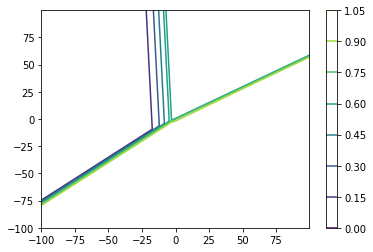

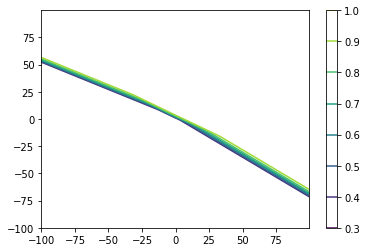

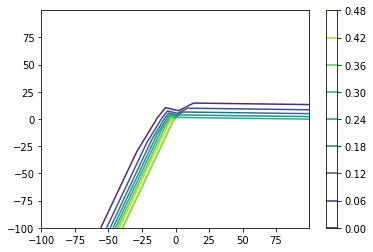

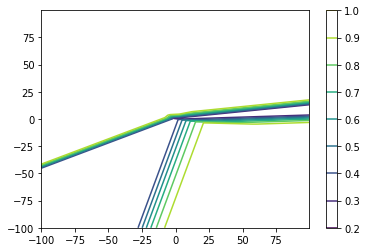

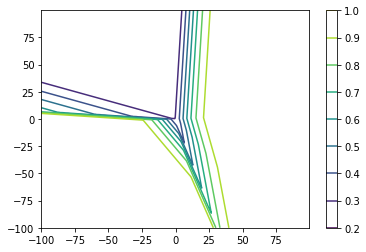

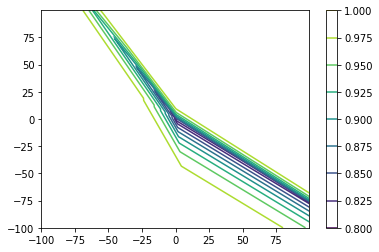

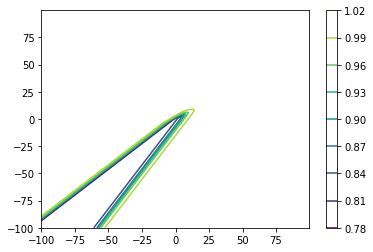

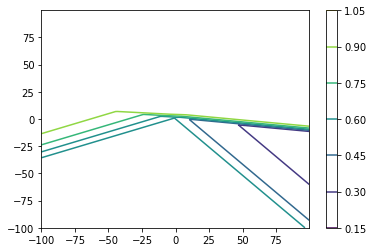

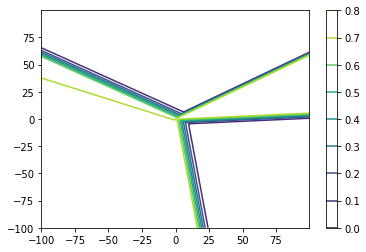

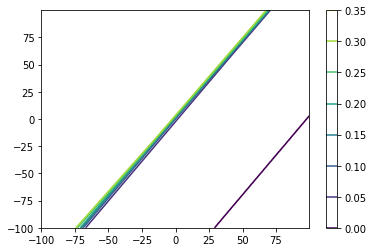

In [51]:
for model_val in model_vals:
    plt.contour(grid_x, grid_y,model_val.reshape(grid_x.shape), )
    plt.colorbar()
    plt.show()

In [58]:
data = torch.cat([data for data, _ in iter(trainloader)])
labels = torch.cat([label for _, label in iter(trainloader)])
data = data.reshape(-1, 28*28)
data_size = data.shape[0]
data = torch.cat((data, db[:,:]))
labels = torch.cat((labels, torch.tensor(db.shape[0]*[2])))

In [140]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(data[:64])
data_reduction = pca.transform(data[:64])

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
plt.scatter(data_reduction[:,0], data_reduction[:,1], c=labels[:data_size])
plt.colorbar()
plt.show()

In [1]:
import plotly.express as px
import pandas as pd
#px.scatter_3d(pd.DataFrame(data_reduction, columns=['x', 'y', 'z']), x='x', y='y', z='z', color=labels[:data_size])